In [1]:
from graphviz import Digraph
import math
import random

In [2]:
class V:
    def __init__(self, data, incoming=(), label=None, op=None):
        self.data = data
        self.grad = 0
        self.chain = lambda: None # local chain rule impl
        self.incoming = set(incoming)
        self.op = op
        self.label = label
        
    def __repr__(self):
        return f'V(label={self.label}, data={self.data}, op={self.op})'
    
    def backward(self):
        topo = topological_sort(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node.chain()
            
    def exp(self):
        out = V(math.exp(self.data), incoming=(self,), op='exp', label='exp')
        
        def chain():
            self.grad += out.data * out.grad
        out.chain = chain
        
        return out
    
    def tanh(self):
        out = V(math.tanh(self.data), incoming=(self,), op='tanh', label='tanh')
        
        def chain():
            self.grad += (1 - out.data**2) * out.grad
        out.chain = chain
        
        return out
        
        
    def __add__(self, other):
        if not isinstance(other, V):
            other = V(other)
            
        out = V(self.data + other.data, incoming=(self, other), op='+', label='add')
            
        def chain():
            # upstream = dL/dout = out.grad
            # local    = dout/dself, dout/dother
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out.chain = chain

        return out
    
    def __mul__(self, other):
        if not isinstance(other, V):
            other = V(other)
            
        out = V(self.data * other.data, incoming=(self, other), op='×', label='mul')
            
        def chain():
            # upstream = dL/dout = out.grad
            # local    = dout/dself, dout/dother
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out.chain = chain
            
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = V(self.data ** other, incoming=(self,), op=f'^{other}', label='pow')
        
        def chain():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out.chain = chain
        
        return out
    
    def __neg__(self): 
        return self * -1

    def __radd__(self, other): 
        return self + other

    def __sub__(self, other): 
        return self + (-other)

    def __rsub__(self, other): 
        return other + (-self)

    def __rmul__(self, other): 
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

In [3]:
def build_expr_graph(root: V) -> Digraph:
    def dfs(root) -> tuple["nodes", "edges"]:
        nodes, edges = set(), set()
        def _inner(n):
            if n in nodes:
                return    
            nodes.add(n)
            for n2 in n.incoming:
                edges.add((n2, n))
                _inner(n2)
        _inner(root)
        return nodes, edges

    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left -> right

    nodes, edges = dfs(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{" + f"{n.label} | data {n.data:.7f} | grad {n.grad:.7f}" + "}", shape='record')

        # node is result of an operation, has incoming edges
        if n.op is not None:
            dot.node(name=uid + n.op, label=n.op)
            dot.edge(uid + n.op, uid) # edge from op node to the result
            pass
            
    for u, v in edges:
        assert v.op is not None
        dot.edge(str(id(u)), str(id(v)) + v.op) # edge from node to the op it's used
        
    return dot

In [4]:
def topological_sort(root: V) -> list[V]:
    nodes = []
    vis = set()
    
    def _inner(n):
        if n in vis:
            return
        
        vis.add(n)
        for n2 in n.incoming:
            _inner(n2)
        nodes.append(n)
    
    _inner(root)
    return nodes

In [5]:
a = V(-0.5, label='a')
b = V(1.2, label='b')

c = a * b; c.label = 'c'
d = a + b; d.label = 'd'
e = c * d; e.label = 'e'

y = e.tanh(); y.label ='y'

y.backward()

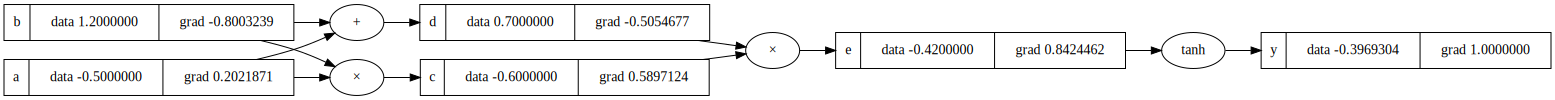

In [6]:
build_expr_graph(y)

In [7]:
import torch as T

In [8]:
a = T.tensor(-0.5, requires_grad=True)
b = T.tensor(1.2, requires_grad=True)
c = a * b; c.retain_grad()
d = a + b; d.retain_grad()
e = c * d; e.retain_grad()
y = e.tanh()
y.backward()

for t in [a, b, c, d, e]:
    print(t.grad.item())

0.20218712091445923
-0.8003239631652832
0.589712381362915
-0.5054677724838257
0.8424462080001831


<img src="https://miro.medium.com/max/1400/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="400"/>

In [9]:
class Neuron:
    def __init__(self, num_inputs: int):
        self.w = [V(random.uniform(-1, 1), label=f'w{i}') for i in range(num_inputs)]
        self.b = V(random.uniform(-1, 1), label='b')
        
    def __call__(self, x):
        out = sum((wi * xi for (wi, xi) in zip(self.w, x)), self.b)
        return out.tanh()
    
    def params(self):
        return [*self.w, self.b]
    
class Layer:
    def __init__(self, num_inputs: int, num_outputs: int):
        self.ns = [Neuron(num_inputs) for _ in range(num_outputs)]
        
    def __call__(self, x):
        return [n(x) for n in self.ns]
    
    def params(self):
        return sum([n.params() for n in self.ns], [])
    
class MLP:
    def __init__(self, num_inputs: int, layer_sizes: list[int]):
        sz = [num_inputs, *layer_sizes]
        self.layers = [Layer(l, r) for l, r in zip(sz[:-1], sz[1:])]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def params(self):
        return sum([l.params() for l in self.layers], [])

In [10]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

xs = [
    [0, 0], [0, 1], [1, 0], [1, 1]
]
ys = [-1, 1, 1, -1]

In [12]:
net = MLP(num_inputs=len(xs[0]), layer_sizes=[4, 4, 1])

LR_MAX = 1.0
LR_MIN = 0.25
EPOCHS = 200

for epoch in range(EPOCHS):

    for p in net.params():
        p.grad = 0
        
    pred = [net(x) for x in xs]
    loss = sum((y_[0] - y)**2 for (y_, y) in zip(pred, ys))
    loss = loss / len(ys)
    
    if epoch % 10 == 0:
        print(f"{epoch=} | {loss.data=:.7f}")
        print("\t", [p[0].data for p in pred])

    loss.backward()
    
    t = epoch / (EPOCHS-1)
    lr = (1 - t) * LR_MAX + t * LR_MIN
    
    for p in net.params():
        p.data += -lr * p.grad

epoch=0 | loss.data=1.0662044
	 [-0.23985770735917555, -0.4107789349005546, -0.06797947619517021, -0.25426272263762817]
epoch=10 | loss.data=1.2381128
	 [-0.8045186597620023, -0.8600221655211603, -0.20029068188656085, -0.8822793531453621]
epoch=20 | loss.data=0.7240535
	 [-0.2965693721902994, 0.7822154198700204, -0.3731506237543074, -0.31558293686639716]
epoch=30 | loss.data=0.9933868
	 [-0.9874747423228425, 0.9506762993708493, -0.9926965566450232, -0.9891415541050536]
epoch=40 | loss.data=0.8652973
	 [-0.8043382302741108, 0.9302267509584176, -0.8386689335781093, -0.8067798750464689]
epoch=50 | loss.data=1.0007479
	 [-0.988776156625057, 0.9010670720858664, -0.9982333412665421, -0.9881121277315498]
epoch=60 | loss.data=0.9985825
	 [-0.9837786812816105, 0.9467223946334891, -0.997725578662613, -0.9820894135577997]
epoch=70 | loss.data=0.9975627
	 [-0.9795239216122866, 0.956267771720024, -0.9968554235286269, -0.977924145407663]
epoch=80 | loss.data=0.9958181
	 [-0.9736111982827463, 0.95970